# HackerEarth Deep Learning Challenge 1 : Predicting the Product Category

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [3]:
import os,sys
from PIL import Image
import cv2
from tqdm import tqdm

In [4]:
DATA_HOME_DIR = os.getcwd()
%pwd

'/output'

## Reading the image labels

In [5]:
train = pd.read_csv("/data/train.csv")
test = pd.read_csv("/data/test.csv")

In [6]:
train.head()

,image_id,label
0,train_1a,rice
1,train_1b,candy
2,train_1c,jam
3,train_1d,coffee
4,train_2a,vinegar


In [7]:
train.groupby(by = "label").count()

,image_id
label,
beans,88
cake,105
candy,242
cereal,181
chips,118
chocolate,199
coffee,194
corn,63
fish,71


In [8]:
## set path for images
TRAIN_PATH = '/data/train_img/'
TEST_PATH = '/data/test_img/'

Let's check out a few images from the training set along with their labels. 
Resizing pixelates the text part of the image.

In [9]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    return img

In [10]:
train_data = []
test_data = []
train_labels = train['label'].values

for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:54<00:00, 31.56it/s]


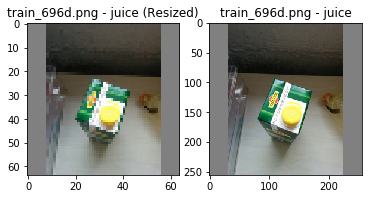

In [111]:
i = np.random.choice(np.arange(len(train_data)))
fig, ax = plt.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title('{}.png - {} (Resized)'.format(train['image_id'].values[i], train_labels[i]))
plt.imshow(train_data[i])

plt.subplot(1,2,2)
plt.title('{}.png - {}'.format(train['image_id'].values[i], train_labels[i]))
plt.imshow(Image.open(TRAIN_PATH +'{}.png'.format(train.image_id[i])))

In [36]:
# Scale the images
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [13]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_labels)

ohe = OneHotEncoder(categorical_features = 'all')
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

In [15]:
## Reshaping train and test images
#X_train = X_train.reshape(X_train.shape[0], 3, 64, 64)
#X_test = X_test.reshape(X_test.shape[0], 3, 64, 64)

In [37]:
X_train.shape, y_train.shape

((3215, 64, 64, 3), (3215, 25))

Let's train simple Keras CNN models

In [17]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


### Model 1 : Deep CNN architecture with/without Dropout

In [46]:
model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (64,64,3)))
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [47]:
opt = SGD(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 128)       73856     
__________

In [49]:
early_stops = EarlyStopping(patience=5, monitor='val_acc')

In [54]:
# Training the model
model.fit(X_train, y_train, batch_size=64, epochs=2, validation_split=0.2, callbacks=[early_stops])

Train on 2572 samples, validate on 643 samples
Epoch 1/2
2572/2572 [==============================] - 15s - loss: 1.2601 - acc: 0.6093 - val_loss: 3.4285 - val_acc: 0.2271
Epoch 2/2
2572/2572 [==============================] - 15s - loss: 0.9806 - acc: 0.6878 - val_loss: 3.8672 - val_acc: 0.2473


In [53]:
model.optimizer.lr = 0.0005

Model heavily overfitted (20 epochs). Let's see the predictions on these and then we'll move to pre-trained models

### Making predictions on test set

In [55]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [86]:
predictions[13:21]

array([13,  5,  0, 23,  8, 16, 16, 21])

In [79]:
unique_labels = np.unique(train['label'].tolist())

In [84]:
# Converting predicted category numbers to predicted labels
pred_labels = unique_labels[predictions]

I see this product is tomatosauce


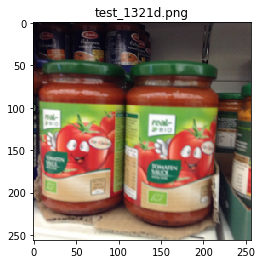

In [110]:
## lets see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
print('I see this product is {}'.format(pred_labels[i]))
plt.title('{}.png'.format(test['image_id'].values[i]))
plt.imshow(Image.open(TEST_PATH +'{}.png'.format(test.image_id[i])))

In [112]:
# Prepare submission file
subm = pd.DataFrame({'image_id':test.image_id, 'label':pred_labels})
subm.to_csv('results.csv', index=False)